# After sales text clustering using Doc2Vec
## Adding CODART and Characteristics from A3ERP and improving the text preprocessing

## Data preprocessing (Merging the translated text)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import date
import os
pd.options.mode.chained_assignment = None


today_date = date.today().isoformat()
data_base_path = f"../DATA/processed/{today_date}"
model_base_path = f"../MODELS/{today_date}"


In [2]:
def query_data(query):
    """
    Function to query data from the database using sqlalchemy
    :param query: 
    :return: pd.DataFrame
    
    Connection parameters:
    user = readmyzone
    password = (get from environment variable MYSQL_PASSWORD)
    host = 192.168.2.7
    port = 3306
    """
    
    # Create the connection string
    user = 'readmyzone'
    password = os.environ.get('MYSQL_PASSWORD')
    host = '192.168.2.7'
    port = '3306'
    db = 'myzone'
    connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'
    
    # Create the engine
    engine = create_engine(connection_string)
    
    try:
        # Query the data
        data = pd.read_sql(query, engine)
    except Exception as e:
        print(e)
        data = None
    
    return data

## Load the data

In [3]:
sav_incidencias = query_data('SELECT * FROM sav_incidencias')
sav_piezas = query_data('SELECT * FROM sav_piezas')
sav_estados = query_data('SELECT * FROM sav_estados')
sav_incidencias_tipo = query_data('SELECT * FROM sav_incidencias_tipo')

In [4]:
dataset = sav_incidencias.merge(sav_piezas, left_on='codigo', right_on='codigo_incidencia', how='left', suffixes=(None, '_pieza'))
dataset = dataset.merge(sav_estados, left_on='estado', right_on='id', how='left', suffixes=(None, '_estado'))
dataset = dataset.merge(sav_incidencias_tipo, left_on='tipo', right_on='id', how='left', suffixes=(None, '_tipo'))

In [5]:
dataset['modification_date'] = pd.to_datetime(dataset['modification_date'], errors='coerce')
clean_dataset = dataset[(dataset["tipo"] == 1) & (dataset["estado"].isin([2,6])) & (dataset['modification_date'] < '2024-05-09')]

In [6]:
# Load from disk the text to translate dictionary
fields_to_translate = ["desc_problema", "problema", "descripcion"]
text_to_translate = {}
for text in fields_to_translate:
    text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')
C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(f"../DATA/{text}.csv", sep='¬', encoding='utf-8-sig')
C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\1421433580.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; 

In [7]:
desc_problema_translated = pd.read_csv("../DATA/desc_problema_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')
descripcion_translated = pd.read_csv("../DATA/descripcion_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')
problema_translated = pd.read_csv("../DATA/problema_translated.csv", sep='¬', encoding='utf-8-sig', engine='python')# Data preprocessing (Merging the translated text)

In [8]:
# Delete rows with values (desc_problema, desc_problema_translated)
desc_problema_translated = desc_problema_translated[~desc_problema_translated["desc_problema_translated"].isin(["desc_problema_translated"])]
descripcion_translated = descripcion_translated[~descripcion_translated["descripcion_translated"].isin(["descripcion_translated"])]
problema_translated = problema_translated[~problema_translated["problema_translated"].isin(["problema_translated"])]

In [9]:
desc_problema_translated.count()

desc_problema               18099
desc_problema_translated    18099
dtype: int64

In [10]:
# Merge the translated text with the text_to_translate dataframe
desc_problema_translated = text_to_translate["desc_problema"].merge(desc_problema_translated, left_on="desc_problema", right_on="desc_problema", how="left")
descripcion_translated = text_to_translate["descripcion"].merge(descripcion_translated, left_on="descripcion", right_on="descripcion", how="left")
problema_translated = text_to_translate["problema"].merge(problema_translated, left_on="problema", right_on="problema", how="left")

In [11]:
# Fill NA with the original texts
desc_problema_translated.fillna({"desc_problema_translated": desc_problema_translated["desc_problema"]}, inplace=True)
descripcion_translated.fillna({"descripcion_translated": descripcion_translated["descripcion"]}, inplace=True)
problema_translated.fillna({"problema_translated": problema_translated["problema"]}, inplace=True)

In [12]:
desc_problema_translated.head(5)

,desc_problema,desc_problema_lg,desc_problema_translated
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,es,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA,es,NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,es,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,es,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",es,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR"


In [13]:
# Merge the translated text with the original dataset
clean_dataset = clean_dataset.merge(desc_problema_translated, left_on="desc_problema", right_on="desc_problema", how="left")
clean_dataset = clean_dataset.merge(descripcion_translated, left_on="descripcion", right_on="descripcion", how="left")
clean_dataset = clean_dataset.merge(problema_translated, left_on="problema", right_on="problema", how="left")

In [14]:
clean_dataset.describe(include='all')

,id,web_id,codigo,creation_date,modification_date,company_id,user_id,ref_cliente,portes_airzone,devaluacion,...,titulo_en_tipo,titulo_fr_tipo,titulo_it_tipo,titulo_pt_tipo,desc_problema_lg,desc_problema_translated,descripcion_lg,descripcion_translated,problema_lg,problema_translated
count,37186.000000,37186.000000,37186,37186,37186,37186.000000,37186.000000,37166,37186.000000,37186.000000,...,37186,37186,37186,0,34928,34928,29320,27732,37076,35488
unique,NaN,NaN,28523,28485,NaN,NaN,NaN,24517,NaN,NaN,...,1,1,1,0,33,23073,33,10154,32,24452
top,NaN,NaN,MPMAMZZN0E,2023-11-19 14:06:28,NaN,NaN,NaN,RESO MATERIALE ASSISTENZE,NaN,NaN,...,guarantee,garantie,garanzia,NaN,es,NO FUNCIONA,en,TERMOSTATO,es,NO FUNCIONA
freq,NaN,NaN,38,38,NaN,NaN,NaN,278,NaN,NaN,...,37186,37186,37186,NaN,14059,506,7142,631,13494,891
mean,29485.333701,1.586565,NaN,NaN,2021-03-25 08:46:57.270827776,1351.329613,2609.311112,NaN,0.999247,0.000538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.000000,1.000000,NaN,NaN,2015-04-16 16:51:24,0.000000,1.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,14636.250000,1.000000,NaN,NaN,2019-04-12 11:35:17,237.000000,446.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,29822.000000,2.000000,NaN,NaN,2021-10-08 09:48:52,494.000000,1531.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,43663.750000,2.000000,NaN,NaN,2023-03-20 16:33:11.500000,2020.000000,4217.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,58867.000000,5.000000,NaN,NaN,2024-05-08 15:17:04,7667.000000,10289.000000,NaN,1.000000,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
for column in clean_dataset.columns:
    print(f"Column: {column}")

Column: id
Column: web_id
Column: codigo
Column: creation_date
Column: modification_date
Column: company_id
Column: user_id
Column: ref_cliente
Column: portes_airzone
Column: devaluacion
Column: pedido_sage
Column: abono_sage
Column: pedido_a3
Column: abono_a3
Column: tipo
Column: estado
Column: personaaz
Column: dire_envio_id
Column: dire_recogida_id
Column: peso3
Column: volumen3
Column: estadofr
Column: c_mail
Column: c_tel
Column: c_obs
Column: accepted_client
Column: desc_problema
Column: codigo_incidencia
Column: id_pieza
Column: user_id_pieza
Column: cod_articulo
Column: descripcion
Column: num_serie
Column: factura_albaran
Column: problema
Column: is_replacement
Column: creation_date_pieza
Column: modification_date_pieza
Column: id_estado
Column: ref
Column: color
Column: valor
Column: titulo_es
Column: titulo_en
Column: titulo_fr
Column: titulo_it
Column: titulo_pt
Column: id_tipo
Column: titulo_es_tipo
Column: titulo_en_tipo
Column: titulo_fr_tipo
Column: titulo_it_tipo
Colum

In [16]:
# Get only the columns with the fields of interest
text_to_analyse = clean_dataset[['codigo','id_pieza','desc_problema_translated','descripcion_translated','problema_translated','cod_articulo']]
# Fill NA with empty string
text_to_analyse.fillna("", inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\1828152953.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  text_to_analyse.fillna("", inplace=True)


In [17]:
text_to_analyse.loc[:, 'text_to_analyse'] = text_to_analyse['desc_problema_translated'] + ' ' + text_to_analyse['descripcion_translated'] + ' ' + text_to_analyse['problema_translated'] + ' ' + text_to_analyse['cod_articulo']

In [18]:
text_to_analyse.head(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,Y52FA5OT97,5.0,NO FUNCIONA,,NO FUNCIONA,AZC3TACTOCSB,NO FUNCIONA NO FUNCIONA AZC3TACTOCSB
2,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa..."
5,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...
6,ZJYEZZYZFA,87.0,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...
7,ZPEZZJYUE4,106.0,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo..."
8,AZUCYPEX2B,114.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...
9,AZUCYPEX2B,115.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...


## Add CODART from A3ERP

In [19]:
import pyodbc
# Def function to connect with sql server using pyodbc and query data
def query_data_a3(query,database):
    r"""
    Function to query data from a SQL database
    :param query: 
    :param database: 
    :return: pd.DataFrame
    
        Connection parameters:
        - user: voliveira
        - password: (get password from environment variable SQL_PASSWORD)
        - host: ROMPETECHOS\REPLICA
        - port: 53373
    """
    # Create the connection string
    user = 'voliveira'
    password = os.environ.get('SQL_PASSWORD')
    host = r'ROMPETECHOS'
    instance = 'REPLICA'
    port = '53373'
    conn_str = f"DRIVER=SQL Server;SERVER={host}\\{instance},{port};DATABASE={database};UID={user};PWD={password}"

    # Create the connection
    try:
        conn = pyodbc.connect(conn_str)
    except Exception as e:
        print(f'Error creating connection: {e}')
        return None
    
    # query the data
    try:
        data = pd.read_sql(query, conn)
    except Exception as e:
        print(f'Error: {e}')
        data = None
        
    return data

In [20]:
# Query the data from A3ERP
articulos = query_data_a3(f'SELECT CODART, DESCART, CAR1, CAR2, CAR3, CAR4 FROM dbo.ARTICULO','Altra')
caracteristicas = query_data_a3(f'SELECT * FROM dbo.CARACTERISTICAS;','Altra')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\1947996995.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


In [21]:
articulos.sample(10)

,CODART,DESCART,CAR1,CAR2,CAR3,CAR4
6607,AZCEZGRPR06L,Plénum de retorno Airzone-Gree 06L,1,253,76,None
44414,RDHV090060APX,Rejilla 2 deflex H/V Airzone 900x600 mm alumin...,2,262,31,77
7926,AZEX8GAL04MST5,Cuello Kit Combo Easyzone Airzone CAI Standard...,1,253,98,30
68544,RSDR040030BPRT,Rejilla simple deflex h Airzone +Reg 400x300 m...,2,262,31,81
17265,AZXEZPAST05L6,Airzone Easyzone Standard + VMC sin electrónic...,1,253,24,30
65265,RLQV175020AKXI,Tramo izquierdo R. lineal 15° deflex V. Airzon...,2,262,31,75
50158,RINT035020BKMRE,Rejilla inteligente Airzone motor triple 350x2...,1,264,31,92
58641,RLQ1050025ATMTE,Rejilla lineal 15° 1 dir Airzone motor 500x250...,1,264,31,84
22814,BRLC1025010BTX,BASE REJILLA INTELIGENTE L.C. 1 DIR 250X100 BL T,5,7,18,79
12085,AZEZ8DAIBS02XS2,Airzone Easyzone CAI Medium IB8 Daikin 2x200 02XS,1,269,24,32


In [22]:
caracteristicas.sample(10)

,CODCAR,DESCCAR,NUMCAR,TIPCAR,ID
342,5,Training in tools,2,C,147
99,65,MP_CHAPAS,3,A,63
176,105,BOCAS DE EXTRACIÓN,4,A,38
399,7,OTROS,6,F,209
320,68,Tornillo,9,A,451
391,6,CALENER,5,F,54
217,168,MP_FABRICA,4,A,143
285,64,Tto Gris,6,A,447
133,101,ZIGBEE,3,A,547
30,250,FLEXA (CE6),2,A,352


In [23]:
def get_unique_caracteristicas(numcar):
    return caracteristicas[(caracteristicas['NUMCAR'] == numcar) & (caracteristicas['TIPCAR'] == 'A')][['CODCAR', 'DESCCAR']]



# Merging the characteristics with the articles
articulos = articulos\
    .merge(get_unique_caracteristicas(1), left_on='CAR1', right_on='CODCAR', how='left', suffixes=(None, '1'))
articulos = articulos\
    .merge(get_unique_caracteristicas(2), left_on='CAR2', right_on='CODCAR', how='left', suffixes=(None, '2'))
articulos = articulos\
    .merge(get_unique_caracteristicas(3), left_on='CAR3', right_on='CODCAR', how='left', suffixes=(None, '3'))
articulos = articulos\
    .merge(get_unique_caracteristicas(4), left_on='CAR4', right_on='CODCAR', how='left', suffixes=(None, '4'))

# Clean usuless columns
articulos = articulos.drop(['CODCAR', 'CODCAR2', 'CODCAR3', 'CODCAR4'], axis=1)
# Rename to match patterns
articulos = articulos.rename(columns={'DESCCAR': 'DESCCAR1'})

In [24]:
articulos.sample(10)

,CODART,DESCART,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4
25738,CPRC070045MTE,Compuerta rectangular conducto motor Airzone 7...,1,264,19,96,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,COMPUERTAS,COMPUERTA RECTANGULAR
31643,FTAZRABFB103,FICHA TECNICA BLUEFACE ECO CABLE AIRZONE RADIA...,6,17,71,172,MATERIAS PRIMAS,MATERIAS PRIMAS,MP_CONSUMIBLES,MP_MKT
21736,BDFLI205650AX,BASE DIFUSOR LINEAL AIRZONE 2 VIAS 5650 AL PUENTE,2,11,34,103,DIFUSIÓN,OBS_DIFUSORES SIN MOTOR,OBS_DIFUSOR SIN REGULACIÓN,DIFUSOR LINEAL
32456,HRPI08153,CUELLO 3Z HITACHI RPI0815,6,17,80,110,MATERIAS PRIMAS,MATERIAS PRIMAS,REEMPLAZOS,MP_ACCESORIOS
29769,E4000952,TIRA PIN MACHO PASO 2.54 ACODADA 40C. AU,6,17,73,142,MATERIAS PRIMAS,MATERIAS PRIMAS,MP_ELECTRONICA,MP_CONECTORES
4901,AM6DAI02M4CB,Pack Easyzone 4 Zonas Cableadas Color Negro pa...,1,253,98,182,SISTEMAS DE ZONAS,EASYZONE (EZ6),PACKS,PLENUM MOTORIZADO
10018,AZEZ6GREST02L7,Airzone Easyzone Standard + VMC IB6 Gree 7x200...,1,253,24,30,SISTEMAS DE ZONAS,EASYZONE (EZ6),PLENUM MOTORIZADO,Plénum Standar (ST)
30123,E4BH5976,BORNA HEMBRA AEREO E4B381H5 + PEGATINA C300097...,6,17,73,142,MATERIAS PRIMAS,MATERIAS PRIMAS,MP_ELECTRONICA,MP_CONECTORES
23490,C1000611,PRECINTO TRANSPARENTE 75x1000 (4 UD CAJA),6,17,71,158,MATERIAS PRIMAS,MATERIAS PRIMAS,MP_CONSUMIBLES,MP_EMBALAJES
68276,RSDR030015ATMTE,Rejilla simple deflex h motor Airzone doble 30...,1,264,31,81,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,REJILLAS,RSDR


In [25]:
from thefuzz import process, fuzz

def find_best_match(cod, codart_list, return_score=True):
    best_match, score = process.extractOne(cod, codart_list, scorer=fuzz.token_set_ratio)
    return (best_match, score) if return_score else best_match

In [26]:
"""# Add the CODART to the text_to_analyse dataframe
text_to_analyse[['CODART_A3','Fuzzy_Score']] = (text_to_analyse['cod_articulo']
                                                .apply(lambda x: pd.Series(find_best_match(x, articulos['CODART'].values))))

# Save to disk
text_to_analyse[['cod_articulo','CODART_A3','Fuzzy_Score']].to_csv("../DATA/fuzzy_matches_w_scores.csv", sep='¬', encoding='utf-8-sig', index=False)"""

# Load fuzzy matches from disk
fuzzy_matches = pd.read_csv("../DATA/fuzzy_matches_w_scores.csv", sep='¬', encoding='utf-8-sig')
fuzzy_matches.drop_duplicates(inplace=True)

# Merge the fuzzy matches with the text_to_analyse dataframe
text_to_analyse = text_to_analyse.merge(fuzzy_matches, left_on='cod_articulo', right_on='cod_articulo', how='left')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\2765930414.py:9: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  fuzzy_matches = pd.read_csv("../DATA/fuzzy_matches_w_scores.csv", sep='¬', encoding='utf-8-sig')


In [27]:
text_to_analyse.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score
26788,ZMDJYWIUEB,65916.0,MOTIVO DEVOLUCION:\r\nHOTLINE 49005,MODULO ZONIFICACION 32 ZONAS CABLE (AZDI6MZZONC),MOTIVO DEVOLUCION:\r\nHOTLINE 49005,AZDI6MZZONC,MOTIVO DEVOLUCION:\r\nHOTLINE 49005 MODULO ZON...,AZDI6MZZONC,100.0
23371,AW5PAWWVC5,57982.0,NO FUNCIONAN LOS ICONOS DE LA PARTE SUPERIOR D...,CABLE TERMOSTATO BLUEFACE ZERO,ENVIAR UN TERMOSTATO NUEVO,AZCE6BLUEZEROCB,NO FUNCIONAN LOS ICONOS DE LA PARTE SUPERIOR D...,AZCE6BLUEZEROCB,100.0
28876,MPAYMJLG99,70733.0,-,TERMOSTATO IBPRO6 MONOCRO,BOLETO N°94079,AZCE6THINKRB,- TERMOSTATO IBPRO6 MONOCRO BOLETO N°94079 AZC...,AZCE6THINKRB,100.0
4864,AWAZA5DQE4,11545.0,Elementos que no funcionan correctamente en la...,TERMOSTATO,"El termostato se pilla, se reinicia solo o no...",AZCE6BLUEFACECB,Elementos que no funcionan correctamente en la...,AZCE6BLUEFACECB,100.0
20930,Y2XLZWMTEF,51626.0,Problema durante la puesta en marcha,,.,AZX6QADAPT3FU2,Problema durante la puesta en marcha . AZX6QA...,AZX6QADAPT3FU2,100.0
35781,M2FRZMRJFC,89006.0,MANUEL GUIRAO LOPEZ Y FCO. HERNANDEZ S.L. INS...,MOTOR DE REJILLA,MOTOR DE REJILLA NO FUNCIONA,AZPVOMOTORMD,MANUEL GUIRAO LOPEZ Y FCO. HERNANDEZ S.L. INS...,AZPV0MOTRMD,87.0
34994,NWNWY2TK07,86922.0,Lunes 15/01/24 se colocó el Airzone de SKY 5.4...,Modulo zonificación AZDI6MZZONC,No funciona,AZDI6MZZONC,Lunes 15/01/24 se colocó el Airzone de SKY 5.4...,AZDI6MZZONC,100.0
3136,YMMXBJ5J72,,FALLO DE COMUNICACIÓN CON RADIOTERMOSTATOS,,,,FALLO DE COMUNICACIÓN CON RADIOTERMOSTATOS,NaN,NaN
1035,BMLJBJ5PC4,2742.0,Problema de cambio de modo.,termostato azul cara blanca,línea directa de expedientes 7459,azcce6bluefacecb,Problema de cambio de modo. termostato azul ca...,AZCE6BLUEFACECB,97.0
21884,ZMLIYWMY68,54097.0,DEVOLUCIÓN DE REPUESTOS ENTREGADOS A NOSOTROS ...,TERMOSTATO MONOCROMO AIRZONE THINK RADIO BLANCO,DESGLOSE,AZCE6THINKRB,DEVOLUCIÓN DE REPUESTOS ENTREGADOS A NOSOTROS ...,AZCE6THINKRB,100.0


In [28]:
# Count the number of NaN values in column CODART_A3
text_to_analyse['CODART_A3'].isna().sum()

1593

In [29]:
# Fill NA with 0
text_to_analyse.fillna('0', inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\1419977797.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  text_to_analyse.fillna('0', inplace=True)


In [30]:
# Clean the text_to_analyse dataframe
#text_to_analyse = text_to_analyse[text_to_analyse['CODART_A3'] != '0']
#text_to_analyse = text_to_analyse[text_to_analyse['CODART_A3'].notna()]
text_to_analyse = text_to_analyse[text_to_analyse['text_to_analyse'].str.len() > 25]
# Clean rows with only NO FUNCIONA in text_to_analyse
text_to_analyse = text_to_analyse[text_to_analyse['text_to_analyse'].str.replace('NO FUNCIONA', '').str.len() > 25]
text_to_analyse.head()

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0
2,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0
3,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0
4,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0
5,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0


In [31]:
# Merge the text_to_analyse with the articulos dataframe
text_to_analyse = text_to_analyse.merge(articulos, left_on='CODART_A3', right_on='CODART', how='left')
text_to_analyse.head()

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,DESCART,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0,MATS,Central de alarmas técnicas multifunción,3,265,94,None,AT HOME,AT HOME,MODULOS DE CONTROL,NaN
1,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0,AZATACTORSB,Termostato Tacto superficie radio (AZA) - Blanco,1,251,91,4,SISTEMAS DE ZONAS,ACUAZONE (DI6),TERMOSTATOS,TACTO
2,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0,PER2,Módulo de control de 2 persianas con pulsador,3,265,94,None,AT HOME,AT HOME,MODULOS DE CONTROL,NaN
3,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0,RINT040015BKMTE,Rejilla Inteligente doble Airzone motorizada 4...,1,264,31,92,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,REJILLAS,RINT
4,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0,AZAMFANCOILC,Módulo de zona fancoil cableado Airzone (AZA),1,251,95,None,SISTEMAS DE ZONAS,ACUAZONE (DI6),MODULOS DE ZONA,NaN


In [32]:
text_to_analyse = text_to_analyse.fillna('')
text_to_analyse = text_to_analyse.copy()
text_to_analyse['text_to_analyse'] = text_to_analyse['desc_problema_translated'] + \
                           ' ' + text_to_analyse['descripcion_translated'] + \
                           ' ' + text_to_analyse['problema_translated'] + \
                           ' ' + text_to_analyse['CODART_A3']

text_to_analyse.head(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,DESCART,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0,MATS,Central de alarmas técnicas multifunción,3,265,94,,AT HOME,AT HOME,MODULOS DE CONTROL,
1,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0,AZATACTORSB,Termostato Tacto superficie radio (AZA) - Blanco,1,251,91,4,SISTEMAS DE ZONAS,ACUAZONE (DI6),TERMOSTATOS,TACTO
2,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0,PER2,Módulo de control de 2 persianas con pulsador,3,265,94,,AT HOME,AT HOME,MODULOS DE CONTROL,
3,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0,RINT040015BKMTE,Rejilla Inteligente doble Airzone motorizada 4...,1,264,31,92,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,REJILLAS,RINT
4,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0,AZAMFANCOILC,Módulo de zona fancoil cableado Airzone (AZA),1,251,95,,SISTEMAS DE ZONAS,ACUAZONE (DI6),MODULOS DE ZONA,
5,ZJYEZZYZFA,87.0,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,AZAMFANCOILC,100.0,AZAMFANCOILC,Módulo de zona fancoil cableado Airzone (AZA),1,251,95,,SISTEMAS DE ZONAS,ACUAZONE (DI6),MODULOS DE ZONA,
6,ZPEZZJYUE4,106.0,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo...",AZXEQADAPMHI,100.0,AZXEQADAPMHI,Pasarela de control MITSUBISHI HEAVY (AZXE),1,260,49,,SISTEMAS DE ZONAS,COMUNES,PASARELAS,
7,AZUCYPEX2B,114.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,Termostato Inteligente Blueface superficie cab...,1,250,91,1,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,BLUEFACE
8,AZUCYPEX2B,115.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3TACTOCSB,100.0,AZC3TACTOCSB,Termostato Tacto Superficie Cable (C3) - Blanco,1,250,91,4,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,TACTO
9,ZJUWZZIT34,116.0,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,,2 UNIDADES. TAPAS TRASERAS ROTAS EN VARIAS OCA...,AZC3BLUEFECOSB,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,Termostato Inteligente Blueface superficie cab...,1,250,91,1,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,BLUEFACE


In [33]:
# Save to disk
os.makedirs(data_base_path, exist_ok=True)
text_to_analyse.to_csv(f"{data_base_path}/text_to_analyse.csv", sep='¬', encoding='utf-8-sig', index=False)

In [33]:
# Load from disk
text_to_analyse = pd.read_csv(f"../DATA/processed/2024-05-13/text_to_analyse.csv", sep='¬', encoding='utf-8-sig')
text_to_analyse.head()

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\2854567637.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_analyse = pd.read_csv(f"../DATA/processed/2024-05-13/text_to_analyse.csv", sep='¬', encoding='utf-8-sig')


,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,DESCART,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0,MATS,Central de alarmas técnicas multifunción,3.0,265.0,94.0,NaN,AT HOME,AT HOME,MODULOS DE CONTROL,NaN
1,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,NaN,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0,AZATACTORSB,Termostato Tacto superficie radio (AZA) - Blanco,1.0,251.0,91.0,4.0,SISTEMAS DE ZONAS,ACUAZONE (DI6),TERMOSTATOS,TACTO
2,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0,PER2,Módulo de control de 2 persianas con pulsador,3.0,265.0,94.0,NaN,AT HOME,AT HOME,MODULOS DE CONTROL,NaN
3,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",NaN,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0,RINT040015BKMTE,Rejilla Inteligente doble Airzone motorizada 4...,1.0,264.0,31.0,92.0,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,REJILLAS,RINT
4,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0,AZAMFANCOILC,Módulo de zona fancoil cableado Airzone (AZA),1.0,251.0,95.0,NaN,SISTEMAS DE ZONAS,ACUAZONE (DI6),MODULOS DE ZONA,NaN


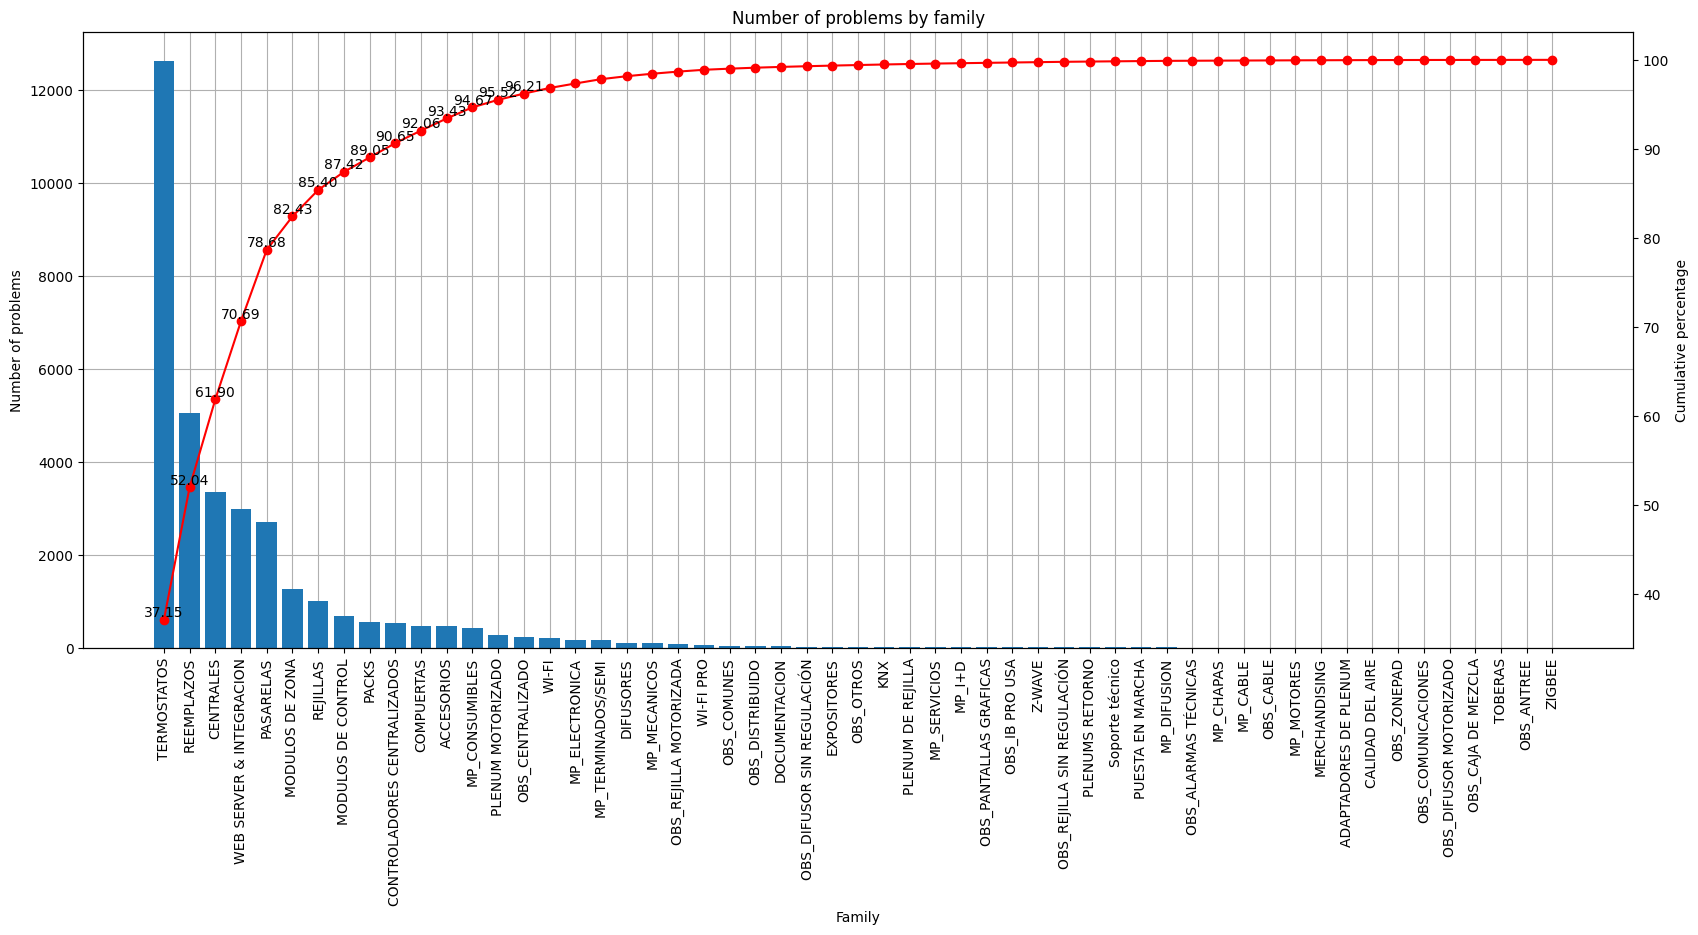

In [34]:
group_by_family = text_to_analyse.groupby('DESCCAR3').size().sort_values(ascending=False)
cummulative_percentage = group_by_family.cumsum() / group_by_family.sum() * 100

# Bars
plt.figure(figsize=(20, 8))
plt.bar(group_by_family.index, group_by_family.values, zorder=2)
plt.xticks(rotation=90)
plt.xlabel('Family')
plt.ylabel('Number of problems')
plt.title('Number of problems by family')
plt.grid(zorder=0)

# Cumulative percentage
plt.twinx()
plt.plot(cummulative_percentage, color='red', marker='o', zorder=2)
plt.ylabel('Cumulative percentage')
# plot the point labels
for i in range(15):
    plt.text(i, cummulative_percentage.values[i], f"{cummulative_percentage.values[i]:.2f}", ha='center', va='bottom', zorder=3)
plt.grid(False)

plt.show()

In [35]:
# Define the families to remove
meanless_families = ['REEMPLAZOS','PACKS','DOCUMENTACION','EXPOSITORES','TOBERAS','MP_CONSUMIBLES', 'OBS_CENTRALIZADO', 'MP_ELECTRONICA', 
                     'MP_TERMINADOS/SEMI', 'MP_MECANICOS', 'OBS_REJILLA MOTORIZADA', 
                     'OBS_COMUNES', 'OBS_DISTRIBUIDO', 
                     'DOCUMENTACION', 'OBS_DIFUSOR SIN REGULACIÓN', 'EXPOSITORES', 
                     'OBS_OTROS', 'MP_SERVICIOS', 'MP_I+D', 'OBS_REJILLA SIN REGULACIÓN', 
                     'OBS_PANTALLAS GRAFICAS', 'OBS_IB PRO USA', 'Soporte técnico', 
                     'PUESTA EN MARCHA', 'MP_DIFUSION', 'OBS_ALARMAS TÉCNICAS', 
                     'MP_CHAPAS', 'MP_CABLE', 'OBS_CABLE', 'MP_MOTORES', 'MERCHANDISING', 
                     'OBS_ZONEPAD', 'OBS_COMUNICACIONES', 'OBS_DIFUSOR MOTORIZADO', 
                     'OBS_CAJA DE MEZCLA', 'OBS_ANTREE']

In [37]:
# Remove the meanless families
text_to_analyse_clean = text_to_analyse[~text_to_analyse['DESCCAR3'].isin(meanless_families)]

In [40]:
# Clean low similariy scores
threashold = 85
text_to_analyse_clean = text_to_analyse_clean[text_to_analyse_clean['Fuzzy_Score'] >= threashold]

In [46]:
# Save to disk
#os.makedirs(data_base_path, exist_ok=True)
#text_to_analyse_clean.to_csv(f"{data_base_path}/text_to_analyse_clean.csv", sep='¬', encoding='utf-8-sig', index=False)

In [255]:
# Load from disk
text_to_analyse_clean = pd.read_csv(f"{data_base_path}/text_to_analyse_clean.csv", sep='¬', encoding='utf-8-sig')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\4028832853.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_analyse_clean = pd.read_csv(f"{data_base_path}/text_to_analyse_clean.csv", sep='¬', encoding='utf-8-sig')


## Train DocVec and save the model

In [256]:
import spacy
nlp = spacy.load('es_core_news_sm')
# nlp = spacy.load('es_core_news_md')
# nlp = spacy.load('es_core_news_sm')
import multiprocessing
from collections import OrderedDict
import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [257]:
# Function to preprocess the text
def preprocess_text(docs):
    texts = [doc for doc in nlp.pipe(docs, disable=["ner", "parser"])] 
    processed_texts = []
    for doc in texts:
        tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_stop and not token.is_space]
        processed_texts.append(' '.join(tokens))
    return processed_texts

In [258]:
# Class Model with comments
class CommentedDoc2Vec(Doc2Vec):
    def __init__(self, comment="", **kwargs):
        super().__init__(**kwargs)
        self.comment = comment

In [50]:
# Load train corpus from disk
corpus = pd.read_csv('../DATA/processed/2024-05-13/corpus.csv')
corpus['processed_text'] = preprocess_text(corpus['text_to_analyse'])
corpus.head()

,text_to_analyse,processed_text
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,indican exclusivamente estropeado iban instala...
1,NO FUNCIONA NO FUNCIONA AZC3TACTOCSB,funciona funciona azc3tactocsb
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,azatactorsb quedado bloqueado permite encender...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,pulsadores subir persianas bajar comprobado en...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",rejilla motorizada defectuosa sustituir rafael...


In [51]:
common_kwargs = dict(
    vector_size=200, 
    epochs=20, 
    min_count=2,
    sample=0, 
    workers=multiprocessing.cpu_count(), 
    negative=5, 
    hs=0,
    seed=0
)

In [ ]:
# PV-DBOW plain
model = CommentedDoc2Vec(
    dm=0, 
    comment=f"PV-DBOW-"
            f"v_size {common_kwargs["vector_size"]}-"
            f"epochs {common_kwargs['epochs']}-"
            f"hs {common_kwargs['hs']}-"
            f"sample {common_kwargs['sample']}-"
            f"negative {common_kwargs['negative']}-"
            f"min_count {common_kwargs['min_count']}",
    **common_kwargs
)

In [ ]:
# Create TaggedDocument objects
tagged_data = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(corpus['processed_text'])]

In [ ]:
# Build the vocabulary
model.build_vocab(tagged_data)
print("Model: %s : vocabulary scanned & state initialized" % model.comment)

In [ ]:
# Train the model using the Corpus
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
print("%s training completed" % model.comment)

In [ ]:
# Save the model
os.makedirs(model_base_path, exist_ok=True)
model_name = f"{model_base_path}/{type(model).__name__}_{model.comment.replace(' ', '_')}.model"
model.save(model_name)
print(f"Model saved at {model_name}")

## Load the model and infer vectors

In [259]:
# Load the model
model_name = "../MODELS/2024-05-13/CommentedDoc2Vec_PV-DBOW-v_size_200-epochs_20-hs_0-sample_0-negative_5-min_count_2.model"
model = CommentedDoc2Vec.load(model_name)
print(f'Model {model} loaded')

Model CommentedDoc2Vec<"PV-DBOW-v_size 200-epochs 20-hs 0-sample 0-negative 5-min_count 2",dbow,d200,n5,mc2,t8> loaded


In [260]:
# Infer vectors for the text_to_analyse
text_to_analyse_clean['processed_text'] = preprocess_text(text_to_analyse_clean['text_to_analyse'])
text_to_analyse_clean['vector'] = text_to_analyse_clean['processed_text'].apply(lambda x: model.infer_vector(x.split()))

In [261]:
text_to_analyse_clean.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4,processed_text,vector
12625,ANBMZMZP42,40061.0,PASARELA FUJITSU NO CONECTA,PASARELA COMUNICACIONES FUJITSU,LA PASARELA NO COMUNICA CON LA CENTRAL Y PROBO...,AZX6GTCFUJ,PASARELA FUJITSU NO CONECTA PASARELA COMUNICAC...,AZX6GTCFUJ,100.0,AZX6GTCFUJ,...,1.0,260.0,49.0,NaN,SISTEMAS DE ZONAS,COMUNES,PASARELAS,NaN,pasarela fujitsu conecta pasarela comunicacion...,"[-0.1446965, 0.19933118, -0.26376566, 0.172177..."
25213,NGFSAWROD7,90880.0,240201149,NaN,240201149,AZX6WSC5GER,240201149 240201149 AZX6WSC5GER,AZX6WSC5GER,100.0,AZX6WSC5GER,...,1.0,260.0,93.0,NaN,SISTEMAS DE ZONAS,COMUNES,WEB SERVER & INTEGRACION,NaN,240201149 240201149 azx6wsc5ger,"[-0.04265877, -0.0052311765, 0.0029296547, 0.0..."
8637,ZMPNAMRM43,27211.0,LLAMO CLIENTE Y LE DIERON CODIGO DE DEVOLUCION...,CE6 TERMOSTATO CABLE MONOVROMO AIRZONE THINK B...,GARANTIZAR,AZCE6THINKCB,LLAMO CLIENTE Y LE DIERON CODIGO DE DEVOLUCION...,AZCE6THINKCB,100.0,AZCE6THINKCB,...,1.0,250.0,91.0,2.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,THINK,llamo cliente codigo devolucion 10489 garantia...,"[-0.08794653, 0.101703085, -0.1561512, 0.12744..."
15481,BNBTA2TO60,48990.0,billete 38477,SERVIDOR WEB DOBLE EN LA NUBE DE AIRZONE,billete 38477,AZX6WSC5GER,billete 38477 SERVIDOR WEB DOBLE EN LA NUBE DE...,AZX6WSC5GER,100.0,AZX6WSC5GER,...,1.0,260.0,93.0,NaN,SISTEMAS DE ZONAS,COMUNES,WEB SERVER & INTEGRACION,NaN,billete 38477 servidor web doble nube airzone ...,"[-0.114349924, -0.16615848, -0.042633925, 0.08..."
1822,CGRNBZDQ6D,5720.0,Reseteo intermitente del termostato,TERMOSTATO BLUEFACE BLANCO,EL TERMOSTATO SE RESETEA SOLO.,AZCEBLUEFACECB,Reseteo intermitente del termostato TERMOSTATO...,AZCE6BLUEFACECB,97.0,AZCE6BLUEFACECB,...,1.0,250.0,91.0,1.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,BLUEFACE,reseteo intermitente termostato termostato blu...,"[-0.040964603, 0.15071103, -0.12947641, 0.1251..."
16575,ZW1GZMABEE,52533.0,"averiado, pero voy a insistir que me den motiv...",RADIOTERMOSTATO FLEXA 3 LITE,NO FUNCIONA ESPERANDO MAS INFO,AZCE6LITERB,"averiado, pero voy a insistir que me den motiv...",AZCE6LITERB,100.0,AZCE6LITERB,...,1.0,250.0,91.0,3.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,LITE,averiado insistir den motivo averia radiotermo...,"[-0.40848988, 0.012182586, -0.15230379, 0.0932..."
23958,LPEDNJVG23,84043.0,NaN,NaN,ENVIAR EN GARANTIA NO FUNCIONA CORRECATMENTE D...,AZCE6THINKRB,ENVIAR EN GARANTIA NO FUNCIONA CORRECATMENTE...,AZCE6THINKRB,100.0,AZCE6THINKRB,...,1.0,250.0,91.0,2.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,THINK,enviar garantia funciona correcatmente problem...,"[-0.17080279, 0.08472696, 0.018988958, -0.0426..."
7717,AMTRZGVS40,23604.0,Continuando con la resolución de problemas rel...,NaN,Continuando con la resolución de problemas rel...,AZDI6BLUEFACECB,Continuando con la resolución de problemas rel...,AZDI6BLUEFACECB,100.0,AZDI6BLUEFACECB,...,1.0,251.0,91.0,1.0,SISTEMAS DE ZONAS,ACUAZONE (DI6),TERMOSTATOS,BLUEFACE,continuando resolución problemas relacionados ...,"[-0.25593174, -0.14950252, 0.16532224, 0.07794..."
5490,LMACNZXL3A,15880.0,Es necesario actualizar sistema para conectar ...,NaN,Necesario actualizar sistema para conectar web...,AZCTACTORSG,Es necesario actualizar sistema para conectar ...,AZCTACTORSG,100.0,AZCTACTORSG,...,1.0,250.0,91.0,4.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,TACTO,necesario actualizar sistema conectar webserwe...,"[0.103929274, 0.17429711, -0.20003694, 0.03215..."
14535,B2HTAMLS2D,45935.0,3 termostatos HS\r\nref azce6bluefacecn s/n: m...,termostato,pantalla de cuadrícula LCD ilegible,azce6bluefacecn,3 termostatos HS\r\nref azce6bluefacecn s/n: m...,AZCE6BLUEFACECN,100.0,AZCE6BLUEFACECN,...,1.0,250.0,91.0,1.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,BLUEFACE,3 termostatos hs ref azce6bluefacecn s n m1138...,"[-0.14142165, -0.1475701, 0.29

## Calculate the similarity between the texts

In [262]:
# Read list of errors
errors = pd.read_csv("../DATA/TablaTipoErrorPostventa.csv", sep=';', header=1)[['Código','CODCAR3','CODCAR2','DESCFAM','Motivo General']]
errors.columns = ['ID_ERROR','CODCAR3','CODCAR2','DESCFAM','DESCRIPCION'] # Rename columns
errors['CODCAR2'] = errors['CODCAR2'].str.replace('-','0').astype(int) # Clean CODCAR2

In [263]:
# Infer vector for errors
errors['description_processed'] = preprocess_text(errors['DESCRIPCION'])
errors['vector'] = errors['description_processed'] .apply(lambda x: model.infer_vector(x.split()))

In [264]:
errors

,ID_ERROR,CODCAR3,CODCAR2,DESCFAM,DESCRIPCION,description_processed,vector
0,3.01,91,0,TERMOSTATOS,Termostato bloqueado,termostato bloqueado,"[-0.07895247, 0.044047154, -0.01566933, 0.0819..."
1,3.02,91,0,TERMOSTATOS,Fallo de comunicaciones,fallo comunicaciones,"[-0.0047488776, 0.03157548, -0.022290185, 0.06..."
2,3.03,91,0,TERMOSTATOS,Fallo de pantalla,fallo pantalla,"[-0.087754674, 0.029924992, -0.02599067, 0.000..."
3,3.04,91,0,TERMOSTATOS,No funciona el táctil,funciona táctil,"[-0.041193094, 0.057277966, -0.03793149, 0.010..."
4,3.05,91,0,TERMOSTATOS,Error de lectura de temperatura,error lectura temperatura,"[-0.133104, 0.1504179, -0.0865719, 0.069296554..."
...,...,...,...,...,...,...,...
109,4.49,100,0,CALIDAD DE AIRE,Otro motivo,motivo,"[-0.0952123, 0.0054122526, -0.049409017, 0.025..."
110,4.61,88,0,ACCESORIOS,Error de alimentación,error alimentación,"[-0.009230697, 0.04668548, -0.057114292, 0.018..."
111,4.62,88,0,ACCESORIOS,Error de funcionamiento,error funcionamiento,"[-0.0896877, 0.026397744, -0.134123, 0.1089146..."
112,4.63,88,0,ACCESORIOS,Error estético,error estético,"[-0.06936058, 0.07036393, -0.028931562, 0.0261..."


In [265]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_score(vector, vector_error):
    return cosine_similarity(vector.reshape(1, -1), vector_error.reshape(1, -1))[0][0]

def calculate_mean_cosine_score(vector, vector_error, n=5):
    if vector.size == 0 or vector_error.size == 0:
        return np.nan  # Return NaN if there's no vector to compare
    cosine_scores = []
    for i in range(n):
        cosine_scores.append(
            calculate_cosine_score(vector, vector_error)
        )
    return np.mean(cosine_scores)

## TODO: Calculate the cosine similarity between the text_to_analyse and the errors
* Get unique errors code
* Calculate all vectors for the unique errors
* Insert vectors to the errors dataframe
* Calculate the cosine similarity with all text_to_analyse for each of the errors descriptions (considering the product family)

In [266]:
# Calculate the cosine similarity between the text_to_analyse and the errors
for index, row in errors.iterrows():
    # Create a condition for filtering
    condition = (text_to_analyse_clean['CAR3'] == row['CODCAR3'])
    if row['CODCAR2']:
        condition &= (text_to_analyse_clean['CAR2'] == row['CODCAR2'])
    
    if not text_to_analyse_clean.loc[condition, 'vector'].empty:
        text_to_analyse_clean.loc[condition, f'cosine_similarity_{row["ID_ERROR"]}'] = text_to_analyse_clean.loc[condition, 'vector'].apply(lambda x: calculate_mean_cosine_score(x, row['vector']))
    
    print(f"Error {row['ID_ERROR']} calculated")

Error 3.01 calculated
Error 3.02 calculated
Error 3.03 calculated
Error 3.04 calculated
Error 3.05 calculated
Error 3.08 calculated
Error 3.09 calculated
Error 3.21 calculated
Error 3.22 calculated
Error 3.23 calculated
Error 3.24 calculated
Error 3.28 calculated
Error 3.29 calculated
Error 3.41 calculated
Error 3.42 calculated
Error 3.43 calculated
Error 3.44 calculated
Error 3.45 calculated
Error 3.48 calculated
Error 3.49 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62

In [267]:
text_to_analyse_clean.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.21,cosine_similarity_4.29,cosine_similarity_4.41,cosine_similarity_4.42,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69
2107,A2GZAZLQ7A,6468.0,control remoto HS,NaN,control remoto HS,AZCE6THINKRB,control remoto HS control remoto HS AZCE6THINKRB,AZCE6THINKRB,100.0,AZCE6THINKRB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20117,BGLMAGWW0F,66355.0,NO FUCIONA,CABLE FANCOIL MÓDULO 32Z,NO FUNCIONA,AZDI6MCFANC,NO FUCIONA CABLE FANCOIL MÓDULO 32Z NO FUNCION...,AZDI6MCFANC,100.0,AZDI6MCFANC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6036,MWQUNJ1TE0,17821.0,VER EXPEDIENTE N° 33301,PANEL DE GESTIÓN DE 6 ZONAS INNOBUS PRO6 2016,VER EXPEDIENTE N° 33301,AZCE6IBPRO6,VER EXPEDIENTE N° 33301 PANEL DE GESTIÓN DE 6 ...,AZCE6IBPRO6,100.0,AZCE6IBPRO6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18936,AMXIYWMU3F,61316.0,"NO SE LO QUE LE PASA A ESTE MATERIAL, EL CLIEN...",SERVIDOR WEB,"NO SE LO QUE LE PASA A ESTE MATERIAL, EL CLIEN...",AZX6WSC5GER,"NO SE LO QUE LE PASA A ESTE MATERIAL, EL CLIEN...",AZX6WSC5GER,100.0,AZX6WSC5GER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20243,M5EZNJVH8D,67010.0,83493,NaN,BOLETO 83493,AZCE8CB1MOT,83493 BOLETO 83493 AZCE8CB1MOT,AZCE8CB1MOT,100.0,AZCE8CB1MOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4557,MGUDNZHS73,13267.0,SE PRODUCEN CHISPAZOS EN LOS TTOS. POR LA ELEC...,OTT. LITE 8Z BLANCO,SON 2 TTOS. PRODUCEN CHISPAZOS POR ELECTRICIDA...,AZCE6LITECB,SE PRODUCEN CHISPAZOS EN LOS TTOS. POR LA ELEC...,AZCE6LITECB,100.0,AZCE6LITECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12776,ZM9TAGHWC5,40568.0,BUENOS DIAS\r\n\r\nEL SERVIDOR WEB NO FUNCIONA,AZX6WSC5GER,BUENOS DIAS\r\n\r\nEL SERVIDOR WEB NO FUNCIONA...,AZX6WSC5GER,BUENOS DIAS\r\n\r\nEL SERVIDOR WEB NO FUNCIONA...,AZX6WSC5GER,100.0,AZX6WSC5GER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18445,A2HLYGIC54,59499.0,"pasarela defectuosa, al instalar la pasarela l...",PASARELA COMUNICACIONES FUJITSU,pasarela de comunicaciones defectuosa,AZX6QADAPT3FU2,"pasarela defectuosa, al instalar la pasarela l...",AZX6QADAPT3FU2,100.0,AZX6QADAPT3FU2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10218,LMVSMW5S61,32864.0,NO FUNCIONA,Termostato de cara azul,Reposición en garantía según la conversación d...,AZCE6BLUEFACECB,NO FUNCIONA Termostato de cara azul Reposición...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9728,KMLPL25Q43,31198.0,CLIENTE HISPANICA DEL AIRE:\r\nLA PLACA DE REL...,NaN,LA PLACA DE RELES NO FUNCIONA Y DEJA TODA LA ...,AZDI6OUTPUT8,CLIENTE HISPANICA DEL AIRE:\r\nLA PLACA DE REL...,AZDI6OUTPUT8,100.0,AZDI6OUTPUT8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
# Save text_to_analyse to disk
#text_to_analyse_clean.to_csv(f"{data_base_path}/text_to_analyse_with_errors.csv", sep='¬', encoding='utf-8-sig', index=False)

In [270]:
# Load text_to_analyse from disk
text_to_analyse_clean = pd.read_csv(f"{data_base_path}/text_to_analyse_with_errors.csv", sep='¬', encoding='utf-8-sig')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\2907262477.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_analyse_clean = pd.read_csv(f"{data_base_path}/text_to_analyse_with_errors.csv", sep='¬', encoding='utf-8-sig')


In [272]:
cosine_columns = [col for col in text_to_analyse_clean.columns if 'cosine_similarity_' in col]
text_to_analyse_clean[cosine_columns] = text_to_analyse_clean[cosine_columns].fillna(0) # Fill NA with 0
text_to_analyse_clean.loc[:, 'highest_score'] = text_to_analyse_clean[cosine_columns].max(axis=1)
text_to_analyse_clean.loc[:, 'highest_score_error'] = text_to_analyse_clean[cosine_columns].idxmax(axis=1).apply(lambda x: x.split('_')[-1])

In [273]:
text_to_analyse_clean.head(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.41,cosine_similarity_4.42,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69,highest_score,highest_score_error
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0,MATS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571141,3.82
1,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,NaN,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0,AZATACTORSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699973,3.05
2,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0,PER2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.353788,3.85
3,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",NaN,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0,RINT040015BKMTE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531677,4.01
4,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0,AZAMFANCOILC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631126,3.82
5,ZJYEZZYZFA,87.0,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,AZAMFANCOILC,100.0,AZAMFANCOILC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.634037,3.82
6,ZPEZZJYUE4,106.0,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo...",AZXEQADAPMHI,100.0,AZXEQADAPMHI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.760100,3.43
7,AZUCYPEX2B,114.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,NaN,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.599900,3.05
8,AZUCYPEX2B,115.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,NaN,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3TACTOCSB,100.0,AZC3TACTOCSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.582140,3.05
9,ZJUWZZIT34,116.0,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,NaN,2 UNIDADES. TAPAS TRASERAS ROTAS EN VARIAS OCA...,AZC3BLUEFECOSB,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.519226,3.05


In [277]:
top10_per_error = text_to_analyse_clean[['codigo','text_to_analyse', 'highest_score', 'highest_score_error']] \
    .groupby('highest_score_error', group_keys=False) \
    .apply(lambda x: x.nlargest(10, 'highest_score')) \
    .reset_index(drop=True)

top10_per_error.head(500)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16892\160105444.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'highest_score')) \


,codigo,text_to_analyse,highest_score,highest_score_error
0,ZMTMBW1T53,EL TERMOSTATO ESTA TOTALMENTE BLOQUEADO TERMOS...,0.934640,3.01
1,BGRPY2DRA7,TERMOSTATO BLOQUEADO TERMOSTATO ESTA BLOQUEADO...,0.932871,3.01
2,MMZPM2LT6C,Termostato bloqueado. TERMOSTATO PENSAR RADIO ...,0.921625,3.01
3,MMZPM2LT6C,Termostato bloqueado. TERMOSTATO PENSAR RADIO ...,0.907969,3.01
4,B3BRA2XS32,LA PANTALLA DEL TERMOSTATO THINK BLOQUEADA el...,0.906206,3.01
...,...,...,...,...
423,NMUWL51O86,MODULOS Y SONDAS ERRONEAS EN PUESTA EN MARCHA ...,0.649598,4.69
424,MMVXBGZPFE,MEDIDOR DE CONSUMO HS CONTADOR DE CONSUMO BOLE...,0.644930,4.69
425,MWDTNW5U60,BOLETO 3084 3084 AZCEZBYPASSST,0.639986,4.69
426,ZMZMZ2OV29,NO FUNCIONA. CABEZAL TERMOSTÁTICO INALAMBRICO ...,0.636880,4.69
